In [2]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofchicago.org,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("v6vf-nfxy", limit=10000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [3]:
results_df.head()

,sr_number,sr_type,sr_short_code,owner_department,status,created_date,last_modified_date,street_address,zip_code,street_number,...,location,:@computed_region_rpca_8um6,:@computed_region_vrxf_vc4k,:@computed_region_6mkv_f3dw,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,closed_date,city,state,parent_sr_number
0,SR20-05039484,Abandoned Vehicle Complaint,SKA,Streets and Sanitation,Open,2020-09-11T12:15:07.000,2020-09-11T12:15:11.000,1721 E 83RD PL,60617,1721,...,"{'latitude': '41.74311965619861', 'longitude':...",25,41,21202,431,35,NaN,NaN,NaN,NaN
1,SR20-05039483,Rodent Baiting/Rat Complaint,SGA,Streets and Sanitation,Open,2020-09-11T12:15:06.000,2020-09-11T12:15:06.000,9811 S MANISTEE AVE,60617,9811,...,"{'latitude': '41.7168832931436', 'longitude': ...",25,48,21202,526,47,NaN,NaN,NaN,NaN
2,SR20-05039482,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,2020-09-11T12:15:05.000,2020-09-11T12:15:05.000,2111 W Lexington ST,60612,2111,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-11T12:15:05.000,Chicago,Illinois,NaN
3,SR20-05039480,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,2020-09-11T12:14:34.000,2020-09-11T12:14:35.000,2111 W Lexington ST,60612,2111,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-11T12:14:35.000,Chicago,Illinois,NaN
4,SR20-05039479,Garbage Cart Maintenance,SIE,Streets and Sanitation,Open,2020-09-11T12:14:31.000,2020-09-11T12:14:33.000,1756 W 74TH ST,60636,1756,...,"{'latitude': '41.75972110674943', 'longitude':...",23,65,22257,433,31,NaN,NaN,NaN,NaN


In [4]:
results_df.shape

(10000, 39)

In [5]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   sr_number                    10000 non-null  object
 1   sr_type                      10000 non-null  object
 2   sr_short_code                10000 non-null  object
 3   owner_department             10000 non-null  object
 4   status                       10000 non-null  object
 5   created_date                 10000 non-null  object
 6   last_modified_date           10000 non-null  object
 7   street_address               9992 non-null   object
 8   zip_code                     9920 non-null   object
 9   street_number                9992 non-null   object
 10  street_direction             9992 non-null   object
 11  street_name                  9992 non-null   object
 12  street_type                  9887 non-null   object
 13  duplicate                    100

In [6]:
results_df.status.value_counts()

Completed    6662
Open         3293
Canceled       45
Name: status, dtype: int64

In [7]:
data = pd.DataFrame(results_df[results_df['status']=='Completed'])

In [8]:
data.shape

(6662, 39)

# Basic Model

To get a first model up and running I'm just going to use the the following:
* type of request as a cateogry 
* the day of the week of the request as a category
* department as a category

My target will be whether or not something was completed within the average length of time for that request.

# Target Creation

I need to:
* Find the mean length of time to complete different projects 
* Create a column for the average length of time to completion for each project based on its type
* Assign a yes/no to each request whether it was done under the time for that type of request

In [9]:
# Create a column for length of time (in days) for each request to be completed
import datetime

data['created_date'] = pd.to_datetime(data['created_date'])

data['closed_date'] = pd.to_datetime(data['closed_date'])

In [10]:
data['time_to_close'] = data['closed_date'] - data['created_date']

In [11]:
hours = []

for x in data['time_to_close']:
    hours.append(x.seconds // 3600)

In [12]:
data['hours_to_close'] = hours

In [13]:
data['hours_to_close'].value_counts()

0     6105
1       85
2       50
3       38
19      35
17      31
16      28
4       27
20      27
15      22
22      22
12      21
21      20
7       20
14      18
18      16
13      15
10      15
6       14
5       12
11      12
23      12
8       10
9        7
Name: hours_to_close, dtype: int64

In [14]:
means = data.groupby('sr_type')['hours_to_close'].mean()

In [15]:
means

sr_type
311 INFORMATION ONLY CALL                   0.000000
Abandoned Vehicle Complaint                 7.864865
Aircraft Noise Complaint                    0.000000
Alley Pothole Complaint                     3.000000
Animal In Trap Complaint                    0.000000
Bee/Wasp Removal                           10.000000
Building Violation                          1.666667
Clean Vacant Lot Request                    4.000000
Coyote Interaction Complaint                8.333333
Dead Animal Pick-Up Request                11.347826
Dead Bird                                  18.000000
E-Scooter                                   0.000000
Fly Dumping Complaint                      11.210526
Garbage Cart Maintenance                    7.666667
Graffiti Removal Request                    2.517663
Home Buyer Program Info Request             6.750000
Low Water Pressure Complaint                8.500000
Missed Garbage Pick-Up Complaint           10.956522
No Water Complaint                    

In [16]:
# From the mean hours to close per service type, add that information to the dataframe
targets = []

for x in data['sr_type']:
    targets.append(means.loc[x])
    
data['avg_time_by_type'] = targets

In [36]:
# Assign yes/no to each request based on if it was completed in less than mean time
completed = []

for x, y in zip(data['hours_to_close'], data['avg_time_by_type']):
    if x <= y:
        completed.append(1)
    else:
        completed.append(0)

In [37]:
data['completed_on_time'] = completed

In [38]:
data.sample(15)

,sr_number,sr_type,sr_short_code,owner_department,status,created_date,last_modified_date,street_address,zip_code,street_number,...,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,closed_date,city,state,parent_sr_number,time_to_close,hours_to_close,avg_time_by_type,completed_on_time
880,SR20-05038273,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,2020-09-11 10:10:56,2020-09-11T10:31:41.000,2111 W Lexington ST,60612,2111,...,5,23,2020-09-11 10:10:56,Chicago,Illinois,NaN,00:00:00,0,0.000000,1
406,SR20-05038908,Graffiti Removal Request,GRAF,Streets and Sanitation,Completed,2020-09-11 11:13:18,2020-09-11T11:13:29.000,1801 W FOSTER AVE,60640,1801,...,106,24,2020-09-11 11:13:29,NaN,NaN,NaN,00:00:11,0,2.517663,1
8262,SR20-05028244,Weed Removal Request,SCP,Streets and Sanitation,Completed,2020-09-10 07:37:00,2020-09-10T07:37:02.000,6038 S MARSHFIELD AVE,60636,6038,...,276,3,2020-09-10 07:37:02,NaN,NaN,NaN,00:00:02,0,0.024390,1
3766,SR20-05034487,Aircraft Noise Complaint,AVN,Aviation,Completed,2020-09-10 16:16:23,2020-09-10T16:31:11.000,10510 W ZEMKE RD,60666,10510,...,668,29,2020-09-10 16:16:23,Chicago,IL,NaN,00:00:00,0,0.000000,1
3446,SR20-05034939,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,2020-09-10 17:11:55,2020-09-10T17:30:57.000,2111 W Lexington ST,60612,2111,...,5,23,2020-09-10 17:11:55,Chicago,Illinois,NaN,00:00:00,0,0.000000,1
3961,SR20-05034242,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,2020-09-10 15:56:17,2020-09-10T16:31:53.000,2111 W Lexington ST,60612,2111,...,5,23,2020-09-10 15:56:18,Chicago,Illinois,NaN,00:00:01,0,0.000000,1
7968,SR20-05028639,Aircraft Noise Complaint,AVN,Aviation,Completed,2020-09-10 08:27:58,2020-09-10T08:30:54.000,10510 W ZEMKE RD,60666,10510,...,668,29,2020-09-10 08:27:59,Chicago,IL,NaN,00:00:01,0,0.000000,1
3156,SR20-05035328,Aircraft Noise Complaint,AVN,Aviation,Completed,2020-09-10 18:26:21,2020-09-10T18:31:13.000,10510 W ZEMKE RD,60666,10510,...,668,29,2020-09-10 18:26:21,Chicago,IL,NaN,00:00:00,0,0.000000,1
9958,SR20-05026164,Aircraft Noise Complaint,AVN,Aviation,Completed,2020-09-09 16:56:39,2020-09-09T17:30:34.000,10510 W ZEMKE RD,60666,10510,...,668,29,2020-09-09 16:56:39,Chicago,IL,NaN,00:00:00,0,0.000000,1
357,SR20-05038975,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,2020-09-11 11:19:42,2020-09-11T11:31:13.000,2111 W Lexington ST,60612,2111,...,5,23,2020-09-11 11:19:42,Chicago,Illinois,NaN,00:00:00,0,0.000000,1


In [39]:
data.shape

(6662, 43)

Target variable is created - 1: completed on time (less than mean for that type of request) or 0: not completed on time.

# Features To Use

For this first model, I just want to get something up and running. Will only use the following features:

* Department
* Community Area

In [40]:
# Set up data using only the above features
data_v1 = data[['owner_department', 'community_area']]

X = pd.get_dummies(data_v1)

In [41]:
X = X.values

In [42]:
y = data['completed_on_time'].values

In [43]:
from sklearn.model_selection import train_test_split

y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2)

In [44]:
print(X_train.shape)
print(X_test.shape)
print(X.shape)

(4996, 85)
(1666, 85)
(6662, 85)


In [45]:
from sklearn.tree import DecisionTreeClassifier

base_model = DecisionTreeClassifier()

base_model.fit(X_train, y_train)

y_pred = base_model.predict(X_test)

In [46]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9375750300120048

In [47]:
# Now we want to visualize the tree
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz


dot_data = StringIO()

# We can do so with export_graphviz
export_graphviz(base_model, out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True, 
                    class_names = ["NO", "YES"])

# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

That seems way overly complicated. Let's created a much more concise tree.

In [48]:
from sklearn.tree import DecisionTreeClassifier

depth3_model = DecisionTreeClassifier(max_depth=3)

depth3_model.fit(X_train, y_train)

y_pred = depth3_model.predict(X_test)

In [49]:
accuracy_score(y_test, y_pred)

0.9429771908763506

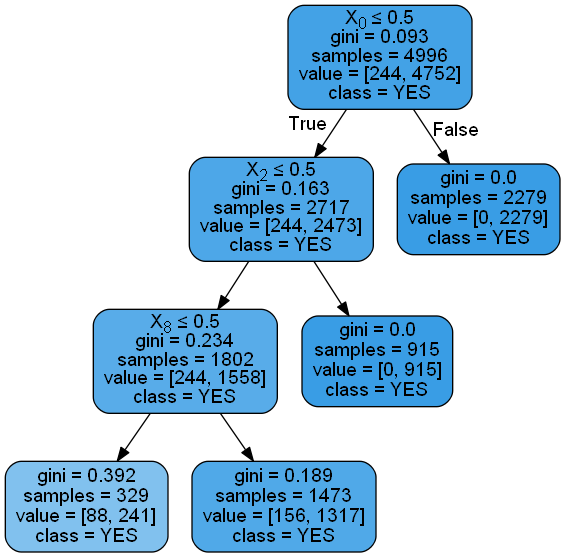

In [50]:
dot_data = StringIO()

# We can do so with export_graphviz
export_graphviz(depth3_model, out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True, 
                    class_names = ["NO", "YES"])

# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

That accuracy score (~94.3%) seems pretty good....but how many of the requests overall go over the average?

In [51]:
data['completed_on_time'].sum()/len(data)

0.9491143800660462

So nearly 95% of the requests are completed on time. These seems like it's due to the fact that such a large number of the requests are completed immediately.

__Next iteration will be to drop those out of the data and see....__